In [161]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import io
from itertools import product


import matplotlib.cm as cmap
subs = np.linspace(0.0, 0.85, 4)
colors = [cmap.viridis(x) for x in subs]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=colors)

plt.rcParams.update({'font.size': 18})

In [5]:
import tensorflow as tf

In [148]:
def get_scalar_events(filename, tag):
    """Gets a list of numbers out of an events file by going through all summaries and looking
    for a specific tag"""
    results = []
    for event in tf.train.summary_iterator(filename):
        for val in event.summary.value:
            if val.tag == tag:
                results.append(val.simple_value)
    return results

def get_some_images(filename):
    """get some sample pictures out of the summary"""
    results = {}
    for event in tf.train.summary_iterator(filename):
        step = event.step
    print(step)
    
def get_run_data(filename):
    steps = []
    losses = []
    images = {}
    for i, event in enumerate(tf.train.summary_iterator(filename)):
        if event.step >= 20000:
            break
        if not steps or event.step != steps[-1]:
            steps.append(event.step)
        for val in event.summary.value:
            if val.tag == 'training/loss':
                losses.append(val.simple_value)
            if val.image and ((i+1) % 100) == 0:
                if steps[-1] not in images:
                    images[steps[-1]] = {}
                images[steps[-1]][val.tag] = val.image.encoded_image_string

    return {'step': np.array(steps),
            'loss': np.array(losses),
            'pics': images}

In [149]:
def subdirs(base_dir):
    return [fname for fname in os.listdir(base_dir)
            if os.path.isdir(os.path.join(base_dir, fname))]

def get_task(task_name, base_dir, cell_filter=None):
    """gets a task (eg. 100x1) from a given directory, loading results for all cells for all learning rates"""
    task_dir = os.path.join(base_dir, task_name)
    # each subdirectory should be a cell name
    cells = subdirs(task_dir)
    if cell_filter is not None:
        cells = [cell for cell in cells if cell in cell_filter]
        
    results = {}
    for cell in cells:
        print(cell)
        results[cell] = {}
        celldir = os.path.join(task_dir, cell)
        for lr in subdirs(celldir):
            results[cell][lr] = {}
            current_base = os.path.join(celldir, lr)
            for run in subdirs(current_base):
                rundir = os.path.join(current_base, run)
                events_file = os.path.join(rundir,
                                           os.listdir(rundir)[0])
                results[cell][lr][run] = get_run_data(events_file)
    return results

In [150]:
onebyone = get_task('100x1', '/Volumes/olossur/Documents/COMP489/2017/variable_binding/noisy/',
                    cell_filter={'gru', 'lstm'})

gru
lstm


In [151]:
onebyone.update(get_task('100x1', '/Users/pfcmathews/Downloads/mcnugget_results/longruns/noisy/', 
                         cell_filter={'tguv2', 'tgu'}))

tgu
tguv2


In [152]:
onebyone.update(get_task('100x1', '/Users/pfcmathews/Downloads/mcnugget_results/longruns/noisy/tanh/'))

tguv2tanh


In [240]:
def plot_median(run_dict, name=None, subsample=50, errorbars=True):
    all_runs = np.stack([run_dict[run]['loss'] for run in run_dict])
    all_runs = all_runs[..., ::subsample]
    medians = np.median(all_runs, axis=0)
    minima = medians - np.min(all_runs, axis=0)
    maxima = np.max(all_runs, axis=0) - medians
    for run in run_dict:
        steps = run_dict[run]['step'][::subsample]
        break
    # plt.plot(steps, medians)
    if errorbars:
        plt.errorbar(steps//100, medians, yerr=[minima, maxima], fmt='-', label=name)
    else:
        plt.plot(steps//100, medians, label=name)

def plot_all(run_dict, subsample=20):
    for run in run_dict:
        run = run_dict[run]
        plt.plot(run['step'][::subsample], run['loss'][::subsample])

(0, 50)

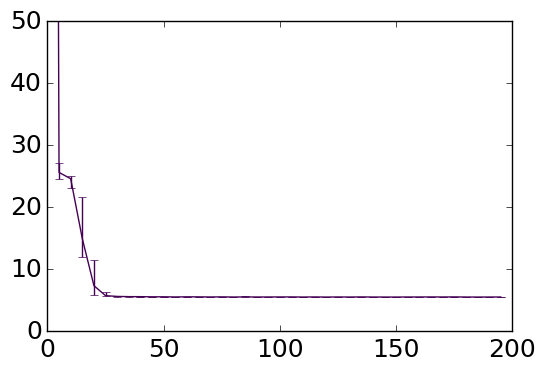

In [241]:
plot_median(onebyone['gru']['0.001'])
plt.ylim(0, 50)

(0, 50)

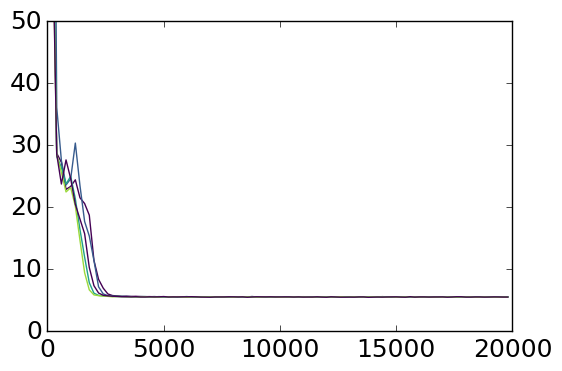

In [242]:
plot_all(onebyone['gru']['0.001'])
plt.ylim(0, 50)

In [156]:
def all_lrs(cell_dict, name):
    for lr in sorted(list(cell_dict.keys())):
        plot_median(cell_dict[lr], name=lr)
    plt.ylim(0, 50)
    plt.title('{} by learning rate'.format(name))
    plt.ylabel('training loss')
    plt.xlabel('minibatch number')
    plt.legend()

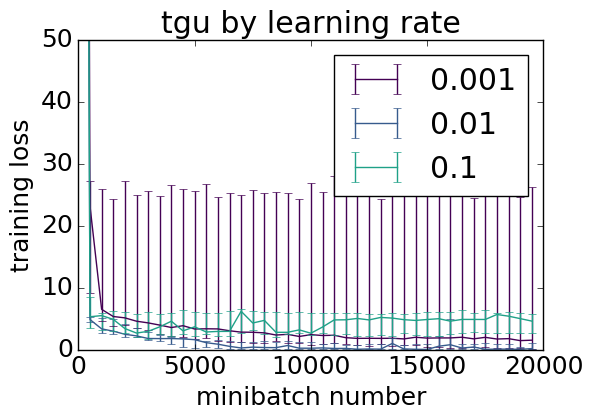

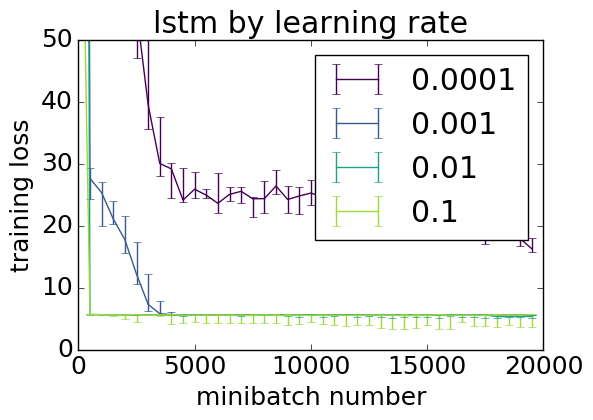

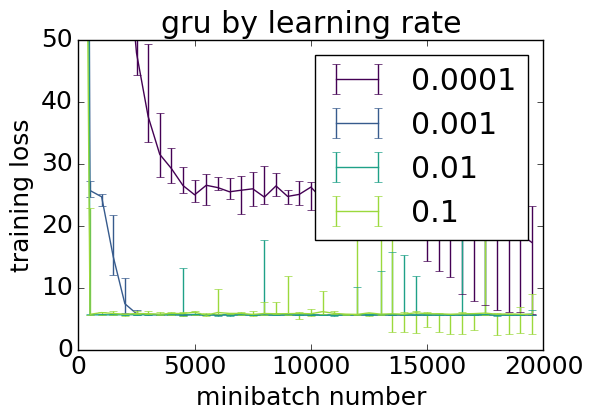

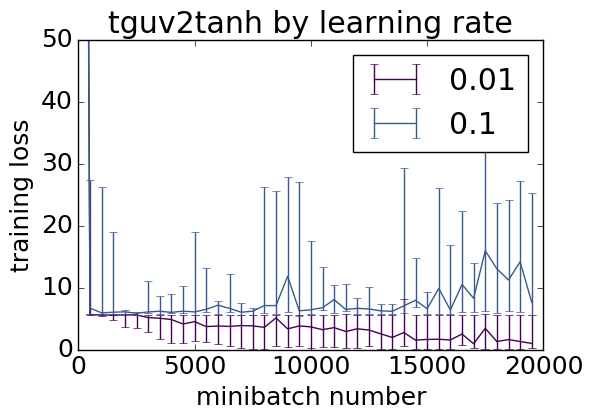

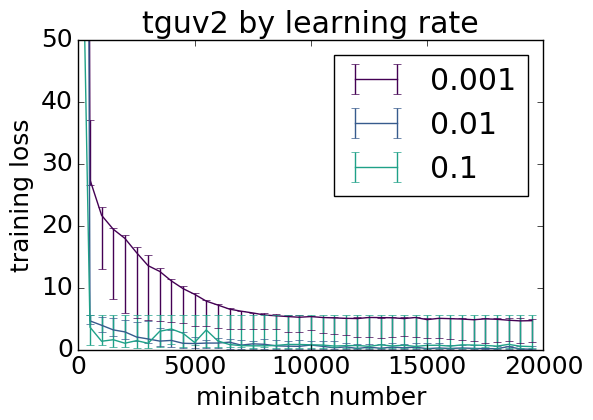

In [157]:
for cell in onebyone:
    all_lrs(onebyone[cell], cell)
    plt.show()

In [233]:
# and the winner is
cell_lrs = {
    'tguv2': '0.1',  # (sigmoid)
    'gru': '0.001',  # same loss but most stable
    'lstm': '0.1'
}

In [243]:
def plot_winners(cell_lrs, all_cells, num_items):
    # figure out the baseline loss
    baseline = num_items * -np.log(0.5) * 8
    for cell, lr in cell_lrs.items():
        plot_median(all_cells[cell][lr], cell, errorbars=False)
    plt.plot([0, 20], [baseline, baseline], '--', color='black')
    plt.ylim(0, 50)
    plt.legend()
    plt.title('100x{}, loss by RNN cell'.format(num_items))
    plt.ylabel('training loss')
    plt.xlabel('minibatch number (hundreds)')

def write_final_pics(run_dict, cell_name, prefix):
    for run in run_dict:
        pic_tags = sorted([int(key) for key in run_dict[run]['pics'].keys()])
        final_step = pic_tags[-1]
        pics = run_dict[run]['pics'][final_step]
        for pic_tag in pics:
            if pics[pic_tag]:
                filename = os.path.join(prefix,
                                        'pictures',
                                        cell_name,
                                        pic_tag[:-1])
                os.makedirs(filename, exist_ok=True)
                filename += pic_tag[-1] + '.png'
                with open(filename, 'wb') as fp:
                    fp.write(pics[pic_tag])
                
    
def example_pictures(cell_lrs, all_cells, prefix):
    for cell, lr in cell_lrs.items():
        write_final_pics(all_cells[cell][lr], cell, prefix)

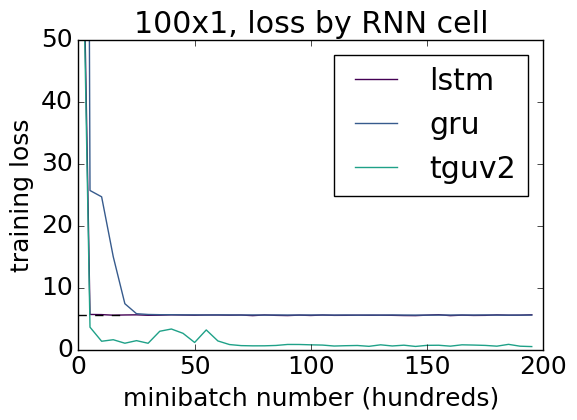

In [244]:
plot_winners(cell_lrs, onebyone, 1)
plt.show()
example_pictures(cell_lrs, onebyone, '100x1_final')

In [218]:
onebytwo = get_task('100x2', '/Volumes/olossur/Documents/COMP489/2017/variable_binding/noisy/',
                    cell_filter={'gru', 'lstm'})

gru
lstm


In [219]:
onebytwo.update(get_task('100x2', '/Users/pfcmathews/Downloads/mcnugget_results/longruns/noisy/', 
                         cell_filter={'tguv2', 'tgu'}))

tgu
tguv2


In [220]:
onebytwo.update(get_task('100x2', '/Users/pfcmathews/Downloads/mcnugget_results/longruns/noisy/tanh/'))

tguv2tanh


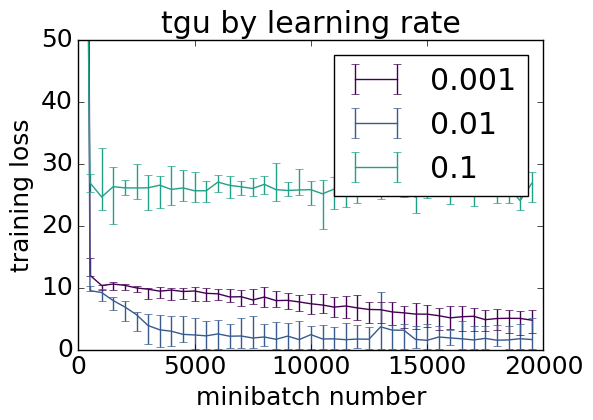

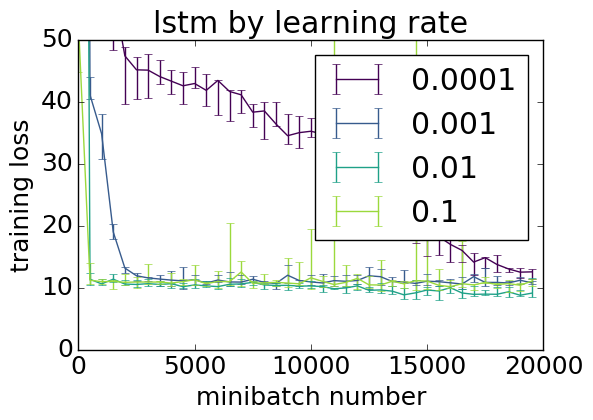

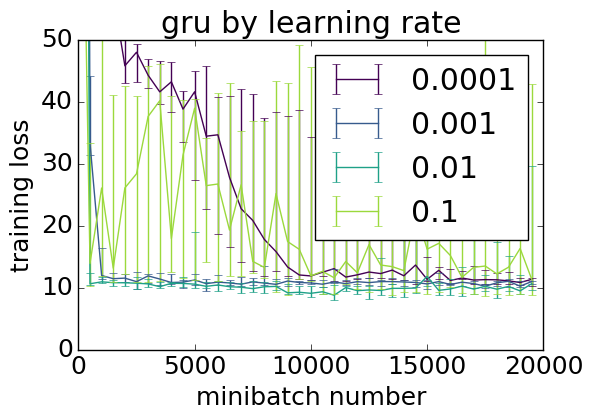

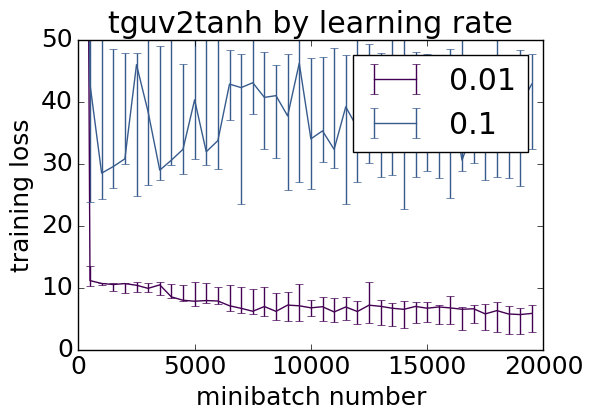

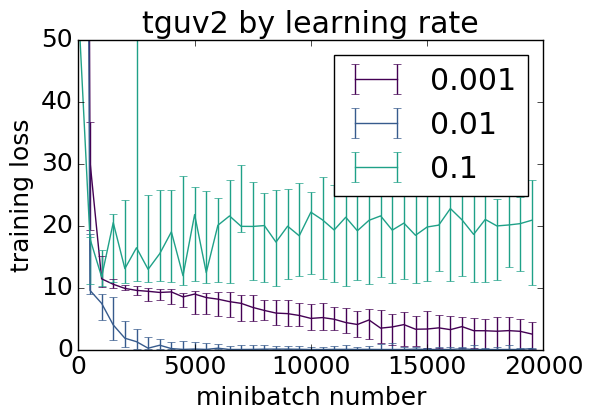

In [221]:
for cell in onebytwo:
    all_lrs(onebytwo[cell], cell)
    plt.show()

In [245]:
# and the winner is
cell_lrs = {
    'tguv2': '0.01',  # (sigmoid)
    'gru': '0.01', 
    'lstm': '0.01'
}

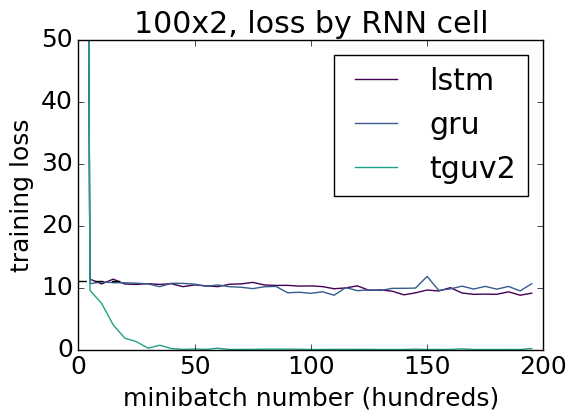

In [246]:
plot_winners(cell_lrs, onebytwo, 2)
plt.show()
example_pictures(cell_lrs, onebytwo, '100x2_final')

In [224]:
onebythree = get_task('100x3', '/Volumes/olossur/Documents/COMP489/2017/variable_binding/noisy/',
                    cell_filter={'gru', 'lstm'})

gru
lstm


In [225]:
onebythree.update(get_task('100x3', '/Users/pfcmathews/Downloads/mcnugget_results/longruns/noisy/', 
                         cell_filter={'tguv2', 'tgu'}))

tgu
tguv2


In [226]:
onebythree.update(get_task('100x3', '/Users/pfcmathews/Downloads/mcnugget_results/longruns/noisy/tanh/'))

tguv2tanh


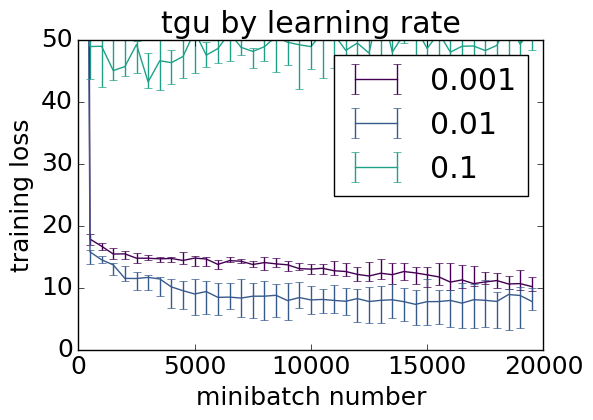

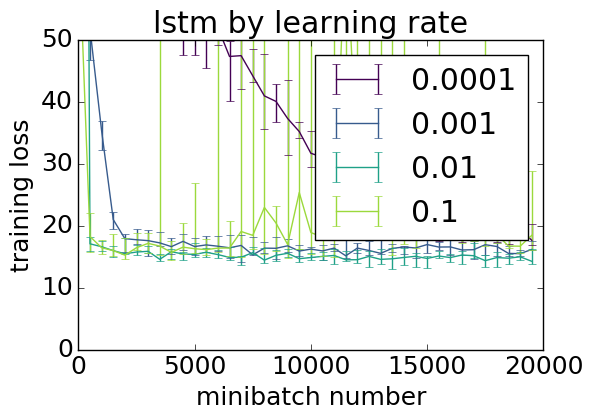

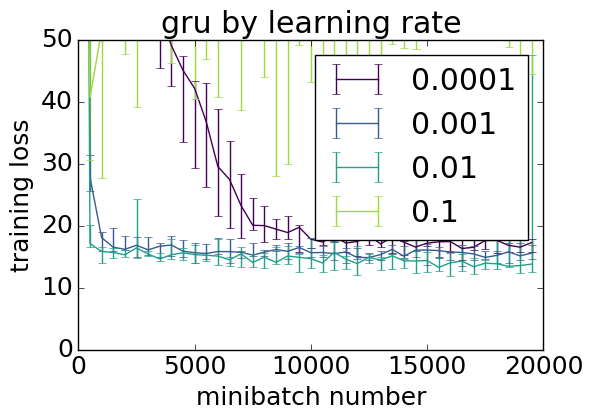

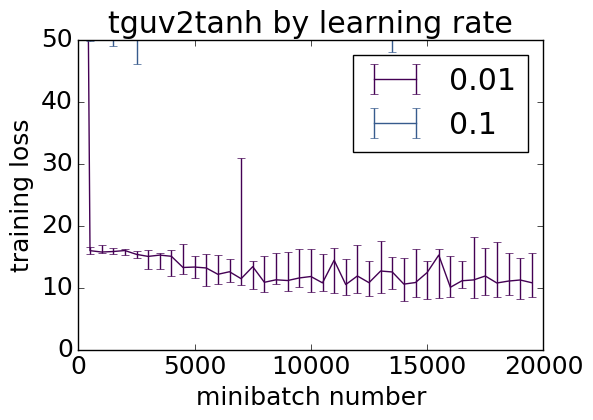

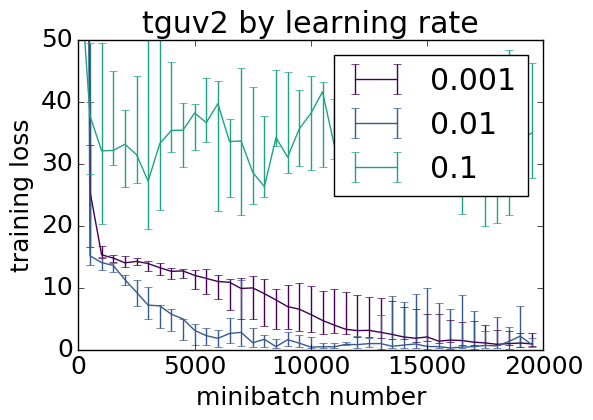

In [227]:
for cell in onebythree:
    all_lrs(onebythree[cell], cell)
    plt.show()

In [247]:
# and the winner is
cell_lrs = {
    'tguv2': '0.01',  # (sigmoid)
    'gru': '0.01', 
    'lstm': '0.01'
}

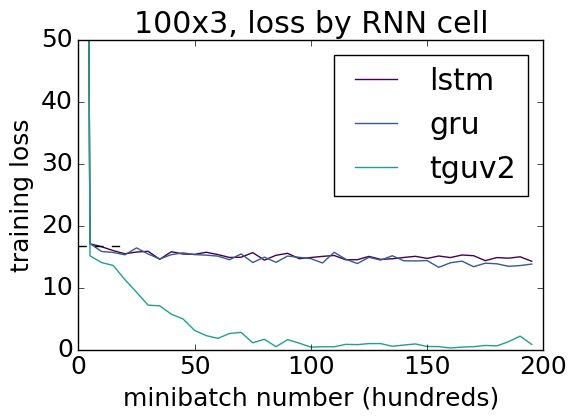

In [248]:
plot_winners(cell_lrs, onebythree, 3)
plt.show()
example_pictures(cell_lrs, onebythree, '100x3_final')